### A few examples of how to transform the data from the sensor to bpm 


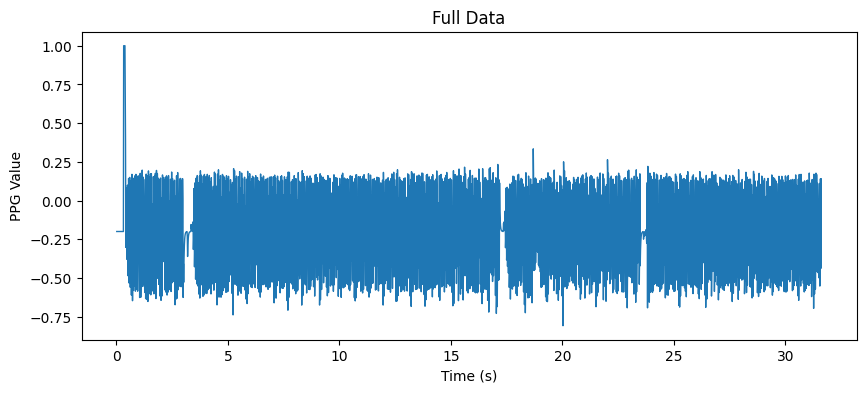

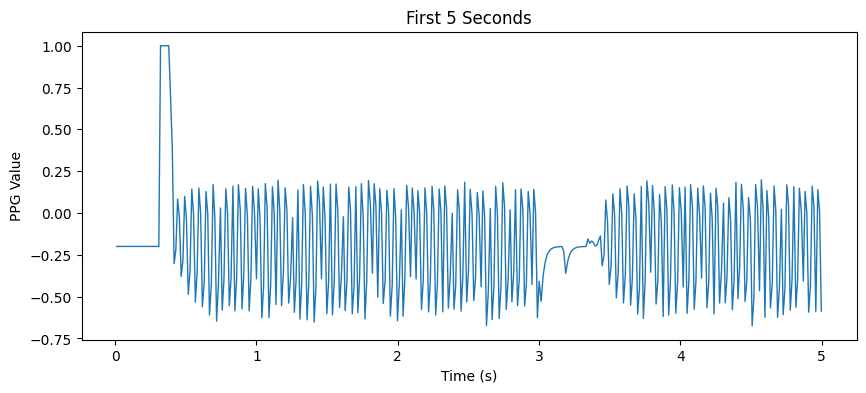

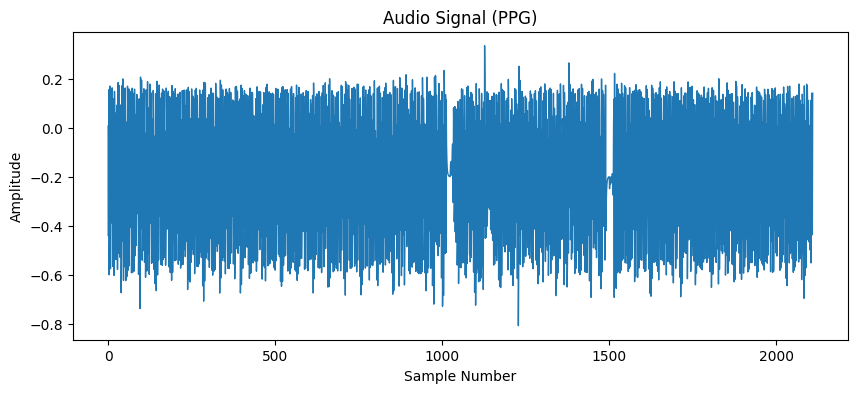

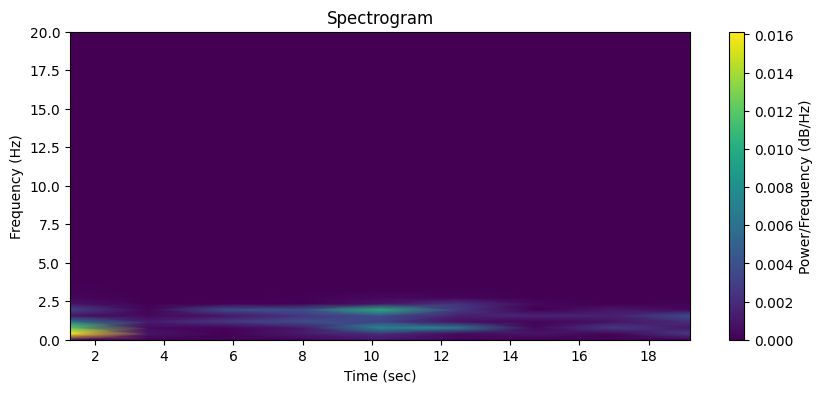

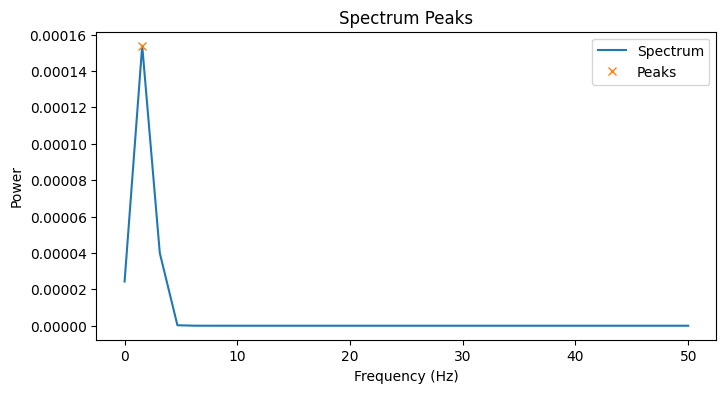

BPM: 93.8


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram, welch, find_peaks

# Load the data
df = pd.read_csv('ppg_data2.csv')


# --- Set sampling rate ---
sampling_rate = 100  # Hz

# --- Plot full data ---
plt.figure(figsize=(10, 4))
plt.plot(df['Time (s)'], df['PPG Value'], lw=1)
plt.xlabel("Time (s)")
plt.ylabel("PPG Value")
plt.title("Full Data")
plt.show()

# --- Plot first 5 seconds of data ---
plt.figure(figsize=(10, 4))
mask = (df['Time (s)'] >= 0) & (df['Time (s)'] <= 5)
plt.plot(df.loc[mask, 'Time (s)'], df.loc[mask, 'PPG Value'], lw=1)
plt.xlabel("Time (s)")
plt.ylabel("PPG Value")
plt.title("First 5 Seconds")
plt.show()

# --- Cut duplicated/extra data (keep data after 4 seconds) ---
ppg = df[df['Time (s)'] > 4]

# --- Convert data to audio signal ---
# Here we simply treat the 'PPG Value' column as our signal.
signal = ppg['PPG Value'].values

plt.figure(figsize=(10, 4))
plt.plot(signal, lw=1)
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.title("Audio Signal (PPG)")
plt.show()

# --- Define bandpass filter function ---
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

######## filter for frequencies below 0.5 Hz (30 BPM) or above 20 Hz (1200 BPM)
filtered_signal = bandpass_filter(signal, lowcut=0.5, highcut=2, fs=sampling_rate, order=4)

# spectrogram 


f, t, Sxx = spectrogram(filtered_signal, fs=sampling_rate, nperseg=256)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, 10 * Sxx, shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.ylim(0, 20)  # set frequency axis from 0 to 20 Hz
plt.title("Spectrogram")
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

#for i in range(2,20):
f_welch, Pxx = welch(filtered_signal, fs=sampling_rate, nperseg=64)

"""
plt.figure(figsize=(8, 4))
plt.plot(f_welch, Pxx)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Mean Spectrum")
plt.show()
"""

# --- Identify spectral peaks ---
# Find all peaks in the spectrum.
peaks_indices, _ = find_peaks(Pxx)
peaks_freqs = f_welch[peaks_indices]
peaks_power = Pxx[peaks_indices]

# Get up to 5 highest peaks (if available)
nmax = 5
if len(peaks_power) > 0:
    # Sort peaks by power (descending)
    sorted_indices = np.argsort(peaks_power)[::-1]
    top_n = sorted_indices[:nmax]
    top_peaks_freqs = peaks_freqs[top_n]
    top_peaks_power = peaks_power[top_n]
    
    # Plot the peaks on the spectrum
    plt.figure(figsize=(8, 4))
    plt.plot(f_welch, Pxx, label='Spectrum')
    plt.plot(top_peaks_freqs, top_peaks_power, "x", label='Peaks')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Spectrum Peaks")
    plt.legend()
    plt.show()
    
    # --- Choose the peak with the highest amplitude ---
    idx_max = np.argmax(top_peaks_power)
    hb_freq = top_peaks_freqs[idx_max]  # in Hz
    bpm = hb_freq * 60  # Convert frequency (Hz) to BPM
    print("BPM: {:.1f}".format(bpm))
else:
    print("No peaks found in the spectrum.")


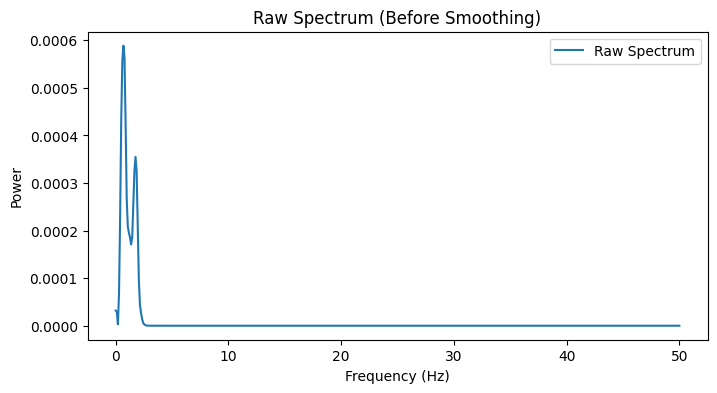

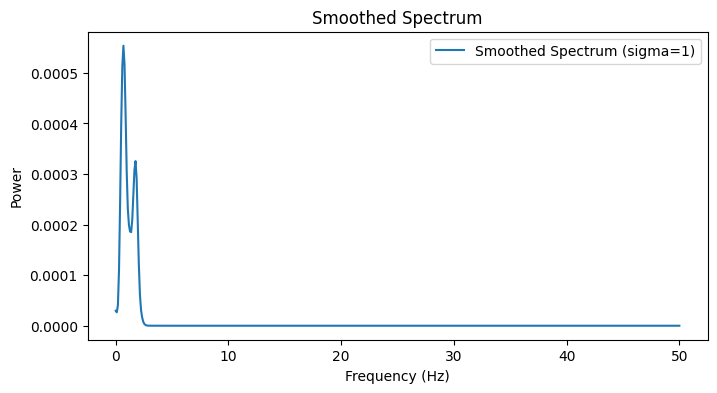

No peaks found in the spectrum. Consider lowering the prominence or adjusting the filter parameters.


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, find_peaks
from scipy.ndimage import gaussian_filter1d

# Load the data
df = pd.read_csv('ppg_data2.csv')

# --- Set sampling rate ---
fs = 100  # Hz

# --- Define bandpass filter function ---
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# --- Process signal ---
signal = df['PPG Value'].values

# Adjust bandpass filter cutoffs if necessary 5*60 = 300 BPM (lower bound) and 20*60 = 1200 BPM (upper bound)
filtered_signal = bandpass_filter(signal, lowcut=0.5, highcut=2, fs=fs, order=4)

# --- Spectral estimation with Welch's method and zero padding ---
nperseg = 256*2  # Increase segment length for better frequency resolution
nfft = 1024    # Zero padding to 1024 points
f_welch, Pxx = welch(filtered_signal, fs=fs, nperseg=nperseg, nfft=nfft)

# Plot the raw spectrum for debugging
plt.figure(figsize=(8, 4))
plt.plot(f_welch, Pxx, label='Raw Spectrum')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Raw Spectrum (Before Smoothing)")
plt.legend()
plt.show()

# --- Smooth the power spectrum (tweak sigma as needed) ---
sigma = 1  # Try a lower sigma to preserve peak shape
Pxx_smooth = gaussian_filter1d(Pxx, sigma=sigma)

plt.figure(figsize=(8, 4))
plt.plot(f_welch, Pxx_smooth, label='Smoothed Spectrum (sigma={})'.format(sigma))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Smoothed Spectrum")
plt.legend()
plt.show()

# --- Identify spectral peaks ---
# Adjust prominence threshold if peaks are too weak; try a lower value
prominence_threshold = 0.1  # Lower the threshold from 0.01 if needed
peaks_indices, properties = find_peaks(Pxx_smooth, prominence=prominence_threshold)
peaks_freqs = f_welch[peaks_indices]
peaks_power = Pxx_smooth[peaks_indices]

if len(peaks_power) == 0:
    print("No peaks found in the spectrum. Consider lowering the prominence or adjusting the filter parameters.")
else:
    # Plot the peaks on the spectrum
    plt.figure(figsize=(8, 4))
    plt.plot(f_welch, Pxx_smooth, label='Smoothed Spectrum')
    plt.plot(peaks_freqs, peaks_power, "x", label='Detected Peaks')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Spectrum Peaks")
    plt.legend()
    plt.show()

    # Get up to 5 highest peaks (if available)
    nmax = 5
    sorted_indices = np.argsort(peaks_power)[::-1]
    top_n = sorted_indices[:nmax]
    top_peaks_freqs = peaks_freqs[top_n]
    top_peaks_power = peaks_power[top_n]

    # Choose the peak with the highest amplitude
    idx_max = np.argmax(top_peaks_power)
    hb_freq = top_peaks_freqs[idx_max]  # in Hz
    bpm = hb_freq * 60  # Convert frequency (Hz) to BPM
    print("BPM: {:.1f}".format(bpm))


In [70]:
import pandas as pd
import numpy as np
import scipy.signal as signal

# ----- Read CSV file -----
# The CSV file should have columns named "Time (s)" and "PPG Value"
data = pd.read_csv('ppg_data_hummingbird_trial.csv')
time = data['Time (s)'].values
ppg = data['PPG Value'].values

# ----- Compute Sampling Frequency -----
# Estimate fs as the reciprocal of the median time difference.
fs = 1 / np.median(np.diff(time))
print("Estimated Sampling Frequency (Hz):", fs)

# ----- Optional: Invert the signal if needed -----
# If your PPG signal peaks are negative, invert the signal.
# ppg = -ppg

# ----- Moving Average Filter -----
# Set window size as fs/5. For fs=100Hz, window_size=20 samples.
window_size = int(fs / 5)
ppg_ma = np.convolve(ppg, np.ones(window_size) / window_size, mode='valid')

# ----- Peak Detection for Hummingbird Heart Rates -----
# For hummingbirds, the heart rate can be very high.
# Here, we set a minimum distance of 0.05 seconds between peaks.
min_interval_sec = 0.05  # minimum interval between heartbeats (seconds)
min_distance = int(min_interval_sec * fs)  # in samples

peaks, _ = signal.find_peaks(ppg_ma, distance=min_distance)

# Adjust peak indices to account for the convolution "delay"
peak_times = time[peaks + window_size // 2]

# ----- Calculate BPM -----
if len(peak_times) > 1:
    intervals = np.diff(peak_times)         # intervals in seconds between successive peaks
    bpms = (60 / intervals)                   # convert intervals to BPM
    heart_rate = np.mean(bpms)                # average BPM over all detected intervals
else:
    heart_rate = None

print("Heart Rate (BPM):", heart_rate)


Estimated Sampling Frequency (Hz): 100.59350165981547
Heart Rate (BPM): 650.9746220341983
